In [9]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

First let's make sure that we have access to a subset of image files from the PASCAL VOC dataset:

In [ ]:
import os.path as op
from zipfile import ZipFile

if not op.exists("images_resize"):
    print('Extracting image files...')
    zf = ZipFile('images_pascalVOC.zip')
    zf.extractall('.')

# Using a pretrained model

Objectives:

- Load a pre-trained ResNet50 pre-trained model using Keras Zoo
- Build a headless model and compute representations of images
- Explore the quality of representation with t-SNE
- Retrain last layer on cat vs dog dataset

In [ ]:
from tensorflow.contrib import keras
from keras.applications.resnet50 import ResNet50
from keras.models import Model
from keras.preprocessing import image

model = ResNet50(include_top=True, weights='imagenet')

In [4]:
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

### Classification of an image

**Exercise**
- Open an image, preprocess it and build a batch of 1 image
- Use the model to classify this image
- Decode the predictions using `decode_predictions` from Keras

Notes:
- Test your code with `"images_resize/000007.jpg"`
- You may need `preprocess_input` for preprocessing the image. 
- The Keras resnet expects floating point images of size `(224, 224)` with a dynamic in `[0, 255]` before preprocessing. [skimage's resize](http://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.resize) has a `preserve_range` flag that you might find useful.

In [5]:
from skimage.io import imread
from skimage.transform import resize
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import decode_predictions

path = "images_resize/000007.jpg"

img = imread(path)

In [7]:
preprocess_input?

/home/rth/.miniconda3/envs/dl-lectures-env/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


convertible 0.9551439
beach_wagon 0.015341434
sports_car 0.011908618
grille 0.006223621
car_wheel 0.0035559535


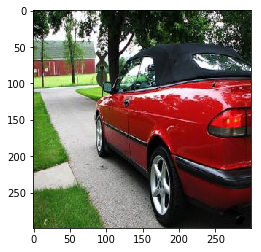

In [10]:
# %load solutions/predict_image.py
from skimage.io import imread
from skimage.transform import resize
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import decode_predictions

path = "images_resize/000007.jpg"

img = imread(path)
plt.imshow(img)

img = resize(img, (224, 224), mode='reflect', preserve_range=True)
# add a dimension for a "batch" of 1 image
img_batch = preprocess_input(img[np.newaxis]) 

predictions = model.predict(img_batch)
decoded_predictions= decode_predictions(predictions)

for s, name, score in decoded_predictions[0]:
    print(name, score)

### Computing the representation of an image

Let's build a new model that maps the image input space to the output of the layer before the last layer of the pretrained Resnet 50 model. We call this new model the "base model":

In [11]:
input = model.layers[0].input
output = model.layers[-2].output
base_model = Model(input, output)
base_model.output_shape

(None, 2048)

The base model can transform any image into a flat, high dimensional, semantic feature vector:

In [12]:
representation = base_model.predict(img_batch)
print("Shape of representation:", representation.shape)

Shape of representation: (1, 2048)


In [13]:
print("Proportion of zeros in the feature vector: %0.3f"
      % np.mean(representation[0] == 0))

Proportion of zeros in the feature vector: 0.122


Computing representations of all images can be time consuming.
This is usually made by large batches on a GPU for massive performance gains.

For the remaining part, we will use pre-computed representations saved in h5 format.

For those interested, this is done using the `process_images.py` script

In [14]:
import os
paths = ["images_resize/" + path
         for path in sorted(os.listdir("images_resize/"))]

In [15]:
import h5py

with h5py.File('img_emb.h5', 'r') as h5f:
    out_tensors = h5f['img_emb'][:]
    
out_tensors.shape

(504, 2048)

In [ ]:
out_tensors.dtype

**Exercise**
- What is the proportion of 0 values in this representation?
- Can you find any negative values?
- Why are there so many zero values?
- Are the zero always located in the same dimensions for different input images?

In [ ]:
# %load solutions/representations.py

Let's find a 2D representation of that high dimensional feature space using T-SNE:

In [16]:
from sklearn.manifold import TSNE

img_emb_tsne = TSNE(perplexity=30).fit_transform(out_tensors)

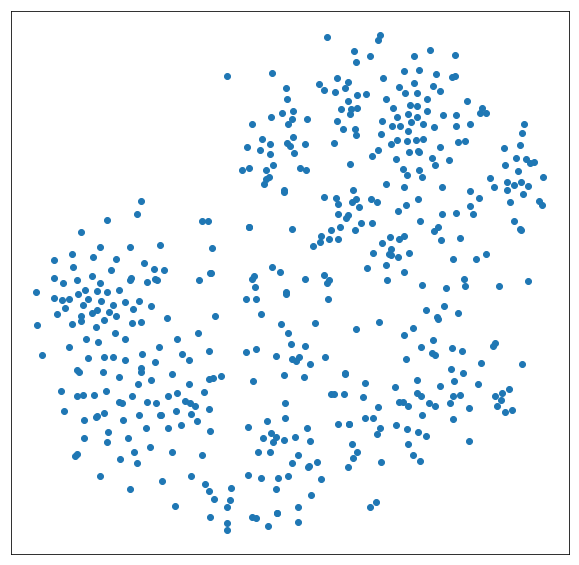

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(img_emb_tsne[:, 0], img_emb_tsne[:, 1]);
plt.xticks(()); plt.yticks(());
plt.show()

Let's add thumnails of the original images at their TSNE locations:

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from skimage.io import imread
from skimage.transform import resize

def imscatter(x, y, paths, ax=None, zoom=1, linewidth=0):
    if ax is None:
        ax = plt.gca()
    x, y = np.atleast_1d(x, y)
    artists = []
    for x0, y0, p in zip(x, y, paths):
        try:
            im = imread(p)
        except:
            print(p)
            continue
        im = resize(im, (224, 224), preserve_range=False, mode='reflect')
        im = OffsetImage(im, zoom=zoom)
        ab = AnnotationBbox(im, (x0, y0), xycoords='data',
                            frameon=True, pad=0.1, 
                            bboxprops=dict(edgecolor='red',
                                           linewidth=linewidth))
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

In [ ]:
fig, ax = plt.subplots(figsize=(50, 50))
imscatter(img_emb_tsne[:, 0], img_emb_tsne[:, 1], paths, zoom=0.5, ax=ax)
plt.savefig('tsne.png')

### Visual Search: finding similar images

In [ ]:
def display(img):
    plt.figure()
    img = imread(img)
    plt.imshow(img)

In [ ]:
idx = 57

def most_similar(idx, top_n=5):
    dists = np.linalg.norm(out_tensors - out_tensors[idx], axis = 1)
    sorted_dists = np.argsort(dists)
    return sorted_dists[:top_n]

sim = most_similar(idx)
[display(paths[s]) for s in sim];

# Classification from Nearest Neighbors?

Using these representations, it may be possible to build a nearest neighbor classifier. However, the representations are learnt on ImageNet, which are centered images, when we input images from PascalVOC, more plausible inputs of a real world system.

The next section explores this possibility by computing the histogram of similarities between one image and the others.

In [ ]:
out_norms = np.linalg.norm(out_tensors, axis=1, keepdims=True)
normed_out_tensors = out_tensors / out_norms

In [ ]:
item_idx = 208
dists_to_item = np.linalg.norm(out_tensors - out_tensors[item_idx],
                               axis=1)
cos_to_item = np.dot(normed_out_tensors, normed_out_tensors[item_idx]) 
plt.hist(cos_to_item)
display(paths[item_idx])

Unfortunately there is no clear separation of class boundaries visible in the histogram of similarities alone. We need some supervision to be able to classify images.

With a labeled dataset, even with very little labels per class, one would be able to:
- build a k-Nearest Neighbor model,
- build a classification model such as a SVM.

These approximate classifiers are useful in practice.
See the `cat vs dog` home assignment with GPU for another example of this approach.

In [ ]:
items = np.where(cos_to_item > 0.44)
print(items)
[display(paths[s]) for s in items[0]];